#Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/CAD/Challenge2/'
#%cd 'drive/My Drive/Colab Notebooks/Challenge2/'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1POyBL_3W8_Os5y9gkOx_0J9aGfupjUqc/CAD/Challenge2


#Importing Libraries

In [ ]:
import os
import torch
import numpy as np
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.transforms.transforms import Resize
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from skimage import io
import re
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

#General Info
In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model.
In feature extraction we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer

# Helper functions for training

In [ ]:
#Helper function for testing the dataset images
def file_checker(PATH,name):
  NV_FOLDER = PATH+'nv/'
  LES_FOLDER = PATH + 'les/'

  NV_IMAGES = [f for f in os.listdir(NV_FOLDER) if os.path.isfile(os.path.join(NV_FOLDER, f))]
  LES_IMAGES = [f for f in os.listdir(LES_FOLDER) if os.path.isfile(os.path.join(LES_FOLDER, f))]

  print("Number of NV Images in the "+str(name)+ " set is: "+str(len(NV_IMAGES)))
  print("Number of LES Images in the "+str(name)+ " set is: "+str(len(LES_IMAGES)))

In [ ]:
#HELPER FUNCTION FOR FINDING MEAN AND STD
def get_mean_std(loader,val_loader):#this gives the approx. If we want the whole then have to do the whole dataset
  mean=0.
  std=0.
  total_img_count=0
  for images,_ in loader:
    total_img = images.size(0)
    images = images.view(total_img,images.size(1),-1)#reshaping
    mean+=images.mean(2).sum(0)
    std+=images.std(2).sum(0)
    total_img_count+=total_img

  for images,_ in val_loader:#this is for val images
    total_img = images.size(0)
    images = images.view(total_img,images.size(1),-1)
    mean+=images.mean(2).sum(0)
    std+=images.std(2).sum(0)
    total_img_count+=total_img

  mean/=total_img_count
  std/=total_img_count
  return mean,std

In [ ]:
#display datagen
def show_transformed_imgs(dataset):
  loader = torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
  batch=next(iter(loader))
  images,labels=batch

  grid=torchvision.utils.make_grid(images,nrow=4)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid,(1,2,0)))
  print("Labels: ",labels)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.array(std) * inp + np.array(mean)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev="cuda:0"
  else:
    dev="cpu"
  return torch.device(dev)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting. By
    default, when we load a pretrained model all of the parameters have
    ``.requires_grad=True``, which is fine if we are training from scratch
    or finetuning. However, if we are feature extracting and only want to
    compute gradients for the newly initialized layer then we want all of
    the other parameters to not require gradients. This will make more sense
    later.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "wide_resnet50":
        """ wide_resnet50_2
        """
        model_ft = models.wide_resnet50_2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "wide_resnet101":
        """ wide_resnet101
        """
        model_ft = models.wide_resnet101_2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "resnext50":
        """ resnext50_32x4d
        """
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "resnext101":
        """ resnext101_32x8d
        """
        model_ft = models.resnext101_32x8d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
      
    elif model_name == "vgg16":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    elif model_name == "densenet161":
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)

    else:
        print("Invalid model name, exiting...")
    return model_ft.to(set_device())

In [ ]:
def save_checkpoint(model,epoch,optimizer,best_acc,mode):
  state={
      "epoch":epoch,
      "model":model.state_dict(),
      "best acc":best_acc,
      "optimizer":optimizer.state_dict(),#save this if we want to do more training later
      "comments":"Batman ist cool und superman ist ein arshloch!!"
  }
  torch.save(state,str(mode)+"_model_best_checkpoint.pth.tar")

In [ ]:
def natural_keys(text):#ASCII to integer
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', text) ]

In [ ]:
def plotMetrics(training_acc, val_acc, training_loss, val_loss, exp_name):
    result_dir = '/content/drive/My Drive/CAD PROJECT/Results/SKIN_RESULTS'
    # training and val accuracy
    epoch_list = tuple(range(0,len(training_acc),1))
    plt.plot(training_acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')    
    acc_path = "./accuracy_"+exp_name+".png"
    plt.savefig(acc_path)
    plt.show()

    # training and val loss
    plt.plot(training_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')    
    loss_path = "./loss_"+exp_name+".png"
    plt.savefig(loss_path) 
    plt.show()

#Confusion matrix

In [ ]:
from sklearn.metrics import classification_report
import itertools
def plot_confusion_matrix(cm, classes,exp_name,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    conf_path = "./conf_"+exp_name+".png"
    plt.savefig(conf_path)

#Initialize Variables

In [ ]:
TRAIN_PATH = './Project1/Training/'
VAL_PATH = './Project1/Validation/'
TEST_PATH = './Project1/Test/'
num_classes = 2
batchsize=16
num_epochs = 2

In [ ]:
#JUST FOR CHECKING
file_checker(TRAIN_PATH,"train")
file_checker(VAL_PATH,"validation")
print("TEST files are "+str(len(os.listdir(TEST_PATH))))

Number of NV Images in the train set is: 2400
Number of LES Images in the train set is: 2400
Number of NV Images in the validation set is: 600
Number of LES Images in the validation set is: 600
TEST files are 1015


# DATAGENERATOR TIME

In [ ]:
#finding the mean and std for 224 resize size
"""training_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
train_dataset=torchvision.datasets.ImageFolder(root=TRAIN_PATH,transform=training_transform)
val_dataset=torchvision.datasets.ImageFolder(root=VAL_PATH,transform=training_transform)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batchsize,shuffle=False)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batchsize,shuffle=False)
mean,std = get_mean_std(train_loader,val_loader)
print(mean)
print(std)"""

'training_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])\ntrain_dataset=torchvision.datasets.ImageFolder(root=TRAIN_PATH,transform=training_transform)\nval_dataset=torchvision.datasets.ImageFolder(root=VAL_PATH,transform=training_transform)\ntrain_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batchsize,shuffle=False)\nval_loader=torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batchsize,shuffle=False)\nmean,std = get_mean_std(train_loader,val_loader)\nprint(mean)\nprint(std)'

In [ ]:
mean = torch.tensor([0.7552, 0.5419, 0.5654])
std  = torch.tensor([0.0827, 0.1160, 0.1308])

train_transform = transforms.Compose([
              transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
              transforms.Resize((224,224)),
             transforms.ColorJitter(brightness=(0.9,1.1), contrast=(0.9,1.1), saturation=(0.9,1.1)),
              transforms.RandomAffine(30,shear=20),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.RandomRotation(degrees = 90),
              transforms.ToTensor(),transforms.Normalize(mean,std)
          ])

val_transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
])

test_transform =transforms.Compose([
        transforms.ToPILImage(),#first convert the numpy array to a PIL Image object using transforms.ToPILImage()
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])

In [ ]:
# load the dataset
train_dataset = datasets.ImageFolder(root=TRAIN_PATH,transform=train_transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH,transform=val_transform)

Labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


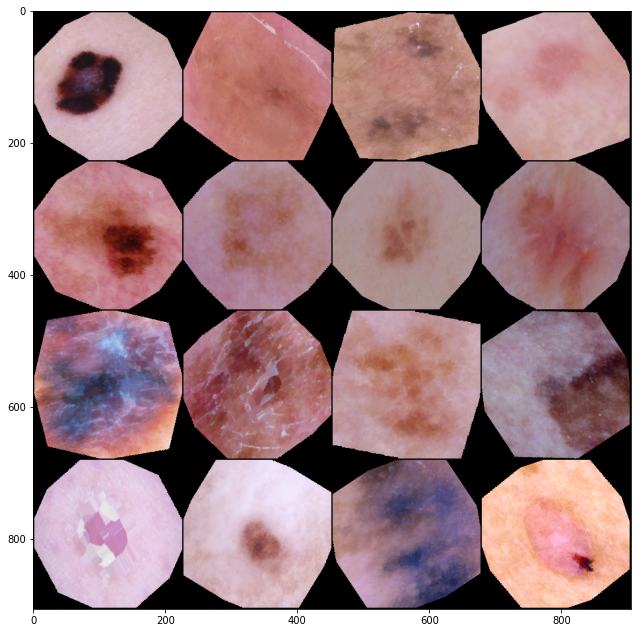

In [ ]:
show_transformed_imgs(train_dataset)

In [ ]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batchsize,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=batchsize,shuffle=True)

In [ ]:
#print(len(train_loader.dataset))
#print(len(val_loader.dataset))

In [ ]:
#now for testing datagenerator
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dirs_all = os.listdir(root_dir)
        self.dirs_all.sort(key=natural_keys)
        self.root_dir = root_dir
        self.transform = transform
        assert len(self.root_dir) != None

    def __len__(self):
        return len(self.dirs_all)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dirs_all[idx])
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        return img_name

In [ ]:
test_dataset = TestDataset(TEST_PATH, test_transform)
#test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batchsize,shuffle=False)
#print(len(test_dataset))

In [ ]:
for a in test_dataset:
  print(a)

./Project1/Test/xx0001.jpg
./Project1/Test/xx0002.jpg
./Project1/Test/xx0003.jpg
./Project1/Test/xx0004.jpg
./Project1/Test/xx0005.jpg
./Project1/Test/xx0006.jpg
./Project1/Test/xx0007.jpg
./Project1/Test/xx0008.jpg
./Project1/Test/xx0009.jpg
./Project1/Test/xx0010.jpg
./Project1/Test/xx0011.jpg
./Project1/Test/xx0012.jpg
./Project1/Test/xx0013.jpg
./Project1/Test/xx0014.jpg
./Project1/Test/xx0015.jpg
./Project1/Test/xx0016.jpg
./Project1/Test/xx0017.jpg
./Project1/Test/xx0018.jpg
./Project1/Test/xx0019.jpg
./Project1/Test/xx0020.jpg
./Project1/Test/xx0021.jpg
./Project1/Test/xx0022.jpg
./Project1/Test/xx0023.jpg
./Project1/Test/xx0024.jpg
./Project1/Test/xx0025.jpg
./Project1/Test/xx0026.jpg
./Project1/Test/xx0027.jpg
./Project1/Test/xx0028.jpg
./Project1/Test/xx0029.jpg
./Project1/Test/xx0030.jpg
./Project1/Test/xx0031.jpg
./Project1/Test/xx0032.jpg
./Project1/Test/xx0033.jpg
./Project1/Test/xx0034.jpg
./Project1/Test/xx0035.jpg
./Project1/Test/xx0036.jpg
./Project1/Test/xx0037.jpg
.

KeyboardInterrupt: ignored

#Training Model

In [ ]:
#inputs, classes = next(iter(train_loader))
#out = torchvision.utils.make_grid(inputs)
#imshow(out)

In [ ]:
class FocalLoss(nn.Module):#Multi-class Focal loss implementation
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        input: [N, C]
        target: [N, ]
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt)**self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss

In [ ]:
def train_nn(model,train_loader,val_loader,criterion,optimizer,mode,n_epochs):
  best_acc=0
  for epoch in range(n_epochs):
    print("EPOCH ",epoch)
    model.train()
    running_loss=0.0
    running_correct=0.0
    total=0

    for images,labels in train_loader:
      images=images.to(set_device())
      labels=labels.to(set_device())
      total+=labels.size(0)
      
      optimizer.zero_grad()#setting gradients to be 0

      outputs=model(images)
      loss = criterion(outputs,labels)

      _,predicted = torch.max(outputs.data,1)#argmax
      loss.backward()
      optimizer.step()

      running_loss+=loss.item()
      running_correct+=(labels==predicted).sum().item()
    epoch_loss=running_loss/len(train_loader)
    epoch_accuracy=100*running_correct/total

    print("Training Acc ",epoch_accuracy, "Epoch_loss ",epoch_loss)
    training_acc.append(epoch_accuracy)
    training_loss.append(epoch_loss)

    test_acc = evaluate_model_on_test_set(model,val_loader,criterion)

    if(test_acc>best_acc):
      best_acc=test_acc
      save_checkpoint(model,epoch,optimizer,best_acc,mode)

  print("best val accuracy is ",str(best_acc))
  return model

In [ ]:
def evaluate_model_on_test_set(model,val_loader,criterion):
  model.eval()
  predicted_correctly_per_epoch=0
  total=0
  running_valloss=0.0
  with torch.no_grad():#reduce memory usage but we cannot do backprop
    
    for images,labels in val_loader:
      images=images.to(set_device())
      labels=labels.to(set_device())
      total+=labels.size(0)

      outputs=model(images)
      loss = criterion(outputs,labels)
      running_valloss+=loss.item()
      _,predicted = torch.max(outputs.data,1)
      predicted_correctly_per_epoch+=(labels==predicted).sum().item()
  
  epoch_loss=running_valloss/len(val_loader)
  epoch_acc = 100* predicted_correctly_per_epoch/total
  val_acc.append(epoch_acc)
  val_loss.append(epoch_loss)
  print("Val acc is ",epoch_acc," and loss ",epoch_loss)
  return epoch_acc

In [ ]:
#model_list= ["resnet","wide_resnet50","wide_resnet101","resnext50","resnext101","alexnet","vgg","vgg16","squeezenet","densenet","densenet161"]
model_list= ["alexnet","vgg"]#,"vgg16","squeezenet","densenet","densenet161"]
class_names = train_dataset.classes#for confusion matrix
loss_fn = FocalLoss()#nn.CrossEntropyLoss()

for mode in model_list:
  training_loss = []
  training_acc = []
  val_loss = []
  val_acc = []
  resnet18_model=initialize_model(mode, num_classes, feature_extract=False, use_pretrained=True)#feature_extract=True
  optimizer = optim.SGD(resnet18_model.parameters(),lr=.01,momentum=.9,weight_decay=0.003)#weight decay to prevent overfitting
  train_nn(resnet18_model,train_loader,val_loader,loss_fn,optimizer,mode,n_epochs=num_epochs)
  plotMetrics(training_acc, val_acc, training_loss, val_loss, mode)
  
  #Now for confusion matrix
  resnet18_model.load_state_dict(str(mode)+"_model_best_checkpoint.pth.tar")
  confusion_matrix = torch.zeros(num_classes, num_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(val_loader):
          inputs = inputs.to(set_device())
          classes = classes.to(set_device())
          
          outputs = resnet18_model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  print("Validation Confusion Matrix:")
  print(confusion_matrix)
  print("\nValidation per-class accuracy:")
  print(confusion_matrix.diag()/confusion_matrix.sum(1))
  plot_confusion_matrix(confusion_matrix,class_names, mode)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

EPOCH  0


KeyboardInterrupt: ignored

# Summary of model

In [ ]:
#summary(resnet18_model, input_size=(3, 224, 224))

#Reloading the model

In [ ]:
class_names = train_dataset.classes
resnext50=initialize_model("resnext50", num_classes, feature_extract=False, use_pretrained=True)
m = nn.Softmax(dim=1)

In [ ]:
test_scans = os.listdir(TEST_PATH)
test_scans.sort()
test_scans.sort(key=len)
print(test_scans)

['xx0001.jpg', 'xx0002.jpg', 'xx0003.jpg', 'xx0004.jpg', 'xx0005.jpg', 'xx0006.jpg', 'xx0007.jpg', 'xx0008.jpg', 'xx0009.jpg', 'xx0010.jpg', 'xx0011.jpg', 'xx0012.jpg', 'xx0013.jpg', 'xx0014.jpg', 'xx0015.jpg', 'xx0016.jpg', 'xx0017.jpg', 'xx0018.jpg', 'xx0019.jpg', 'xx0020.jpg', 'xx0021.jpg', 'xx0022.jpg', 'xx0023.jpg', 'xx0024.jpg', 'xx0025.jpg', 'xx0026.jpg', 'xx0027.jpg', 'xx0028.jpg', 'xx0029.jpg', 'xx0030.jpg', 'xx0031.jpg', 'xx0032.jpg', 'xx0033.jpg', 'xx0034.jpg', 'xx0035.jpg', 'xx0036.jpg', 'xx0037.jpg', 'xx0038.jpg', 'xx0039.jpg', 'xx0040.jpg', 'xx0041.jpg', 'xx0042.jpg', 'xx0043.jpg', 'xx0044.jpg', 'xx0045.jpg', 'xx0046.jpg', 'xx0047.jpg', 'xx0048.jpg', 'xx0049.jpg', 'xx0050.jpg', 'xx0051.jpg', 'xx0052.jpg', 'xx0053.jpg', 'xx0054.jpg', 'xx0055.jpg', 'xx0056.jpg', 'xx0057.jpg', 'xx0058.jpg', 'xx0059.jpg', 'xx0060.jpg', 'xx0061.jpg', 'xx0062.jpg', 'xx0063.jpg', 'xx0064.jpg', 'xx0065.jpg', 'xx0066.jpg', 'xx0067.jpg', 'xx0068.jpg', 'xx0069.jpg', 'xx0070.jpg', 'xx0071.jpg', 'xx00

In [ ]:
test_result_path = './test.csv'

In [ ]:
resnext50.load_state_dict(torch.load("./FINAL MODELS AND RESULTS/proj 1/"+"resnext50_model_best_checkpoint.pth.tar")['model'])

<All keys matched successfully>

In [ ]:
resnext50.to('cuda')
resnext50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import sys
import os
import copy

In [ ]:
#mean = torch.tensor([0.7552, 0.5419, 0.5654])
#std  = torch.tensor([0.0827, 0.1160, 0.1308])
from PIL import Image 
def get_test_loader(test_image_path):
    normalize = transforms.Normalize(
        mean=[0.7552, 0.5419, 0.5654],
        std=[0.0827, 0.1160, 0.1308],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])
    image = Image.open(test_image_path)
    
    image = transform(image).float()
    image_expand = torch.tensor(np.expand_dims(image, axis=0))

    data_loader = image_expand.cuda()

    return data_loader

In [ ]:
ensemble_architectures=["densenet","resnext50"] 
ensemble_models={"densenet_17":2,
                 "resnext50_13":1,}

[[0.181658   0.81834203]]


In [ ]:
import csv
with open(test_result_path, 'w') as csvfile:
  filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
  for i, scan_name in enumerate(test_scans):
    scan_path = os.path.join(TEST_PATH, scan_name)
    #print(scan_path)
    input_image = get_test_loader(scan_path)
    total_prob=np.zeros((1,2))
    outputs = resnext50(input_image)
    outputs = m(outputs)
    total_prob=total_prob+ outputs.cpu().detach().numpy()
    preds = np.argmax(total_prob, 1)
    filewriter.writerow(str(preds))

tensor([[0.0108, 0.9892]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[[0.0108048  0.98919523]]
[1]


In [ ]:
for i, (inputs, classes) in enumerate(train_loader):
  inputs = inputs.to(set_device())
  classes = classes.to(set_device())
  print(classes)
  outputs = densenet161(inputs)
  _, preds = torch.max(outputs, 1)

Validation Confusion Matrix:
tensor([[536.,  64.],
        [ 92., 508.]])

Validation per-class accuracy:
tensor([0.8933, 0.8467])


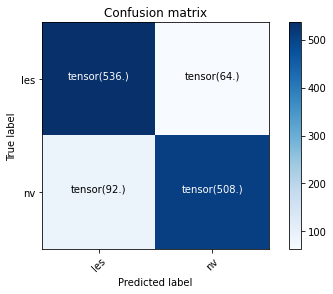

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(set_device())
        classes = classes.to(set_device())
        
        outputs = densenet161(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print("Validation Confusion Matrix:")
print(confusion_matrix)
print("\nValidation per-class accuracy:")
print(confusion_matrix.diag()/confusion_matrix.sum(1))
plot_confusion_matrix(confusion_matrix,class_names, "densenet161")

In [ ]:
print("HELLP")

HELLP


In [ ]:
|"""resnet18_model = models.resnet18()
num_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_features,num_classes)
resnet18_model.load_state_dict(checkpoint['model'])"""

#predicting on test images

In [ ]:
"""y_predict = []
with torch.no_grad():
  for i, (inputs) in enumerate(test_dataloader):
        inputs = inputs.to(set_device())        
        outputs = resnet18_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_predict.extend(np.squeeze(outputs.max(1, keepdim=True)[1].cpu().numpy().T))

# convert from ['les', 'nv'] to classification result (0= nev and 1=les)
import pandas as pd
df = pd.DataFrame(y_predict)
mytime=time.time()
filepath = 'results_'+exp_name +mytime+'.xlsx'

df.to_excel(filepath, index=False)"""